# Notebook for the study of the different formation channels of sdB stars

## General imports and data

In [1]:
import os, sys    # for handling paths
import h5py as h5  #for handling data format
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import Image
from scipy.stats import gaussian_kde

G = 7 * 10**(-8) * (1/7**3) * 10**(-30) * 2 * 10**(33) *(24*60*60)**2

In [2]:
# set path to data file
path = '/home/louism/Thesis/data/COMPAS_Output_13/COMPAS_Output.h5'

# load the file
data = h5.File(path)

# inspect the data
list(data.keys())

['BSE_Common_Envelopes',
 'BSE_Double_Compact_Objects',
 'BSE_RLOF',
 'BSE_Supernovae',
 'BSE_Switch_Log',
 'BSE_System_Parameters',
 'Run_Details']

In [3]:
SLs = data['BSE_Switch_Log']
SPs = data['BSE_System_Parameters']
RLOF = data['BSE_RLOF']
CEs = data['BSE_Common_Envelopes']

### Some additional functions

In [4]:
def printCompasDetails(data, *seeds, mask=()):
    """
    Function to print the full Compas output for given seeds, optionally with an additional mask
    """
    list_of_keys = list(data.keys())

    # Check if seed parameter exists - if not, just print without (e.g RunDetails)
    if ('SEED' in list_of_keys) | ('SEED>MT' in list_of_keys): # Most output files 
        #SEED>MT is a relic from older versions, but we leave this in for backwards compatibility

        # Set the seed name parameter, mask on seeds as needed, and set the index
        seedVariableName='SEED' if ('SEED' in list_of_keys) else 'SEED>MT'
        list_of_keys.remove(seedVariableName) # this is the index above, don't want to include it
    
        allSeeds = data[seedVariableName][()]
        seedsMask = np.in1d(allSeeds, seeds)
        if len(seeds) == 0: # if any seed is included, do not reset the mask
            seedsMask = np.ones_like(allSeeds).astype(bool)
        if mask == ():
            mask = np.ones_like(allSeeds).astype(bool)
        mask &= seedsMask

        df = pd.DataFrame.from_dict({param: data[param][()][mask] for param in list(data.keys())}).set_index(seedVariableName).T

    else: # No seed parameter, so do custom print for Run Details

        # Get just the keys without the -Derivation suffix - those will be a second column
        keys_not_derivations = []
        for key in list_of_keys:
            if '-Derivation' not in key:
                keys_not_derivations.append(key)
        
        # Some parameter values are string types, formatted as np.bytes_, need to convert back
        def convert_strings(param_array):
            if isinstance(param_array[0], np.bytes_):
                return param_array.astype(str)
            else:
                return param_array

        df_keys = pd.DataFrame.from_dict({param: convert_strings(data[param][()]) for param in keys_not_derivations }).T
        nCols = df_keys.shape[1] # Required only because if we combine RDs, we get many columns (should fix later)
        df_keys.columns = ['Parameter']*nCols
        df_drvs = pd.DataFrame.from_dict({param: convert_strings(data[param+'-Derivation'][()]) for param in keys_not_derivations }).T
        df_drvs.columns = ['Derivation']*nCols
        df = pd.concat([df_keys, df_drvs], axis=1)

    # Add units as first col
    units_dict = {key:data[key].attrs['units'].astype(str) for key in list_of_keys}
    df.insert(loc=0, column='(units)', value=pd.Series(units_dict))
    return df


In [5]:
def getMtEvents(MT):                                     
    """
    This function takes in the `BSE_RLOF` output category from COMPAS, and returns the information
    on the Mass Transfer (MT) events that happen for each seed. The events do not have to be in order, 
    either chronologically or by seed, this function will reorder them as required.
    
    OUT:
        tuple of (returnedSeeds, returnedEvents, returnedTimes)
        returnedSeeds (list): ordered list of the unique seeds in the MT file
        returnedEvents (list): list of sublists, where each sublist contains all the MT events for a given seed.
            MT event tuples take the form :
            (stellarTypePrimary, stellarTypeSecondary, isRlof1, isRlof2, isCEE)
        returnTimes (list): is a list of sublists of times of each of the MT events
    """

    mtSeeds = MT['SEED'][()]
    mtTimes = MT['Time<MT'][()]
    mtPrimaryStype = MT['Stellar_Type(1)<MT'][()]
    mtSecondaryStype = MT['Stellar_Type(2)<MT'][()]
    mtIsRlof1 = MT['RLOF(1)>MT'][()] == 1
    mtIsRlof2 = MT['RLOF(2)>MT'][()] == 1
    mtIsCEE = MT['CEE>MT'][()] == 1

    # We want the return arrays sorted by seed, so sort here.
    mtSeedsInds = np.lexsort((mtTimes, mtSeeds)) # sort by seeds then times - lexsort sorts by the last column first...
    mtSeeds = mtSeeds[mtSeedsInds]  
    mtTimes = mtTimes[mtSeedsInds]  
    mtPrimaryStype = mtPrimaryStype[mtSeedsInds]
    mtSecondaryStype = mtSecondaryStype[mtSeedsInds]
    mtIsRlof1 = mtIsRlof1[mtSeedsInds]
    mtIsRlof2 = mtIsRlof2[mtSeedsInds]
    mtIsCEE = mtIsCEE[mtSeedsInds]

    # Process the MT events

    returnedSeeds = []                                      # array of seeds - will only contain seeds that have MT events
    returnedEvents = []                                     # array of MT events for each seed in returnedSeeds
    returnedTimes = []                                      # array of times for each event in returnedEvents (for each seed in returnedSeeds)

    lastSeed = -1                                           # initialize most recently processed seed

    for seedIndex, thisSeed in enumerate(mtSeeds):          # iterate over all RLOF file entries
        thisTime = mtTimes[seedIndex]                       # time for this RLOF file entry
        thisEvent = (mtPrimaryStype[seedIndex], mtSecondaryStype[seedIndex], 
                     mtIsRlof1[seedIndex], mtIsRlof2[seedIndex], mtIsCEE[seedIndex])  # construct event tuple

        # If this is an entirely new seed:
        if thisSeed != lastSeed:                            # same seed as last seed processed?
            returnedSeeds.append(thisSeed)                  # no - new seed, record it
            returnedTimes.append([thisTime])                # initialize the list of event times for this seed
            returnedEvents.append([thisEvent])              # initialize the list of events for this seed
            lastSeed = thisSeed                             # update the latest seed

        # Add event, if it is not a duplicate
        try:
            eventIndex = returnedEvents[-1].index(thisEvent)  # find eventIndex of this particular event tuple in the array of events for this seed 
            if thisTime > returnedTimes[-1][eventIndex]:      # ^ if event is not a duplicate, this will throw a ValueError 
                returnedTimes[-1][eventIndex] = thisTime      # if event is duplicate, update time to the later of the duplicates
        except ValueError:                                    # event is not a duplicate:
            returnedEvents[-1].append(thisEvent)              # record new event tuple for this seed
            returnedTimes[-1].append(thisTime)                # record new event time for this seed

    return returnedSeeds, returnedEvents, returnedTimes       # see above for description

In [6]:
def stellar_types_histogram(data):

    bins = np.arange(0, 16 + 1.5) - 0.5
    xtix = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
    
    SPs = data["BSE_System_Parameters"]

    zams_type_primary = np.array(SPs['Stellar_Type@ZAMS(1)'][()])
    zams_type_secundary = np.array(SPs['Stellar_Type@ZAMS(2)'][()])

    term_type_primary = np.array(SPs['Stellar_Type(1)'][()])
    term_type_secundary = np.array(SPs['Stellar_Type(2)'][()])
    
    fig, ax = plt.subplots(2,2, figsize=(14,10))
    
    ax[0][0].set_title("Stellar Types at ZAMS")
    
    counts00, edges00, bars00 = ax[0][0].hist(zams_type_primary, bins=bins, rwidth=0.8, edgecolor='black', color="blue", label="Primary Companions")
    
    ax[0][0].set_ylabel("Amount")
    ax[0][0].set_xticks(xtix)
    ax[0][0].legend()
    ax[0][0].set_xlabel("Stellar Types")
    ax[0][0].bar_label(bars00)
    
    counts01, edges01, bars01 = ax[0][1].hist(zams_type_secundary, bins=bins, rwidth=0.8, edgecolor='black', color='red', label="Secondary Companions")
    
    ax[0][1].set_ylabel("Amount")
    ax[0][1].set_xticks(xtix)
    ax[0][1].legend()
    ax[0][1].set_xlabel("Stellar Types")
    ax[0][1].bar_label(bars01)
    
    ax[1][0].set_title("Final Stellar Types")
    
    counts10, edges10, bars10 = ax[1][0].hist(term_type_primary, bins=bins, rwidth=0.8, edgecolor='black', color="blue", label="Primary Companions")
    
    ax[1][0].set_ylabel("Amount")
    ax[1][0].set_xticks(xtix)
    ax[1][0].legend()
    ax[1][0].bar_label(bars10)
    
    counts11, edges11, bars11 = ax[1][1].hist(term_type_secundary, bins=bins, rwidth=0.8, edgecolor='black', color='red', label="Secondary Companions")
    
    ax[1][1].set_ylabel("Amount")
    ax[1][1].set_xticks(xtix)
    ax[1][1].legend()
    ax[1][1].bar_label(bars11)
    ax[1][1].set_xlabel("Stellar Types")
    
    plt.show()

## A first look at the data

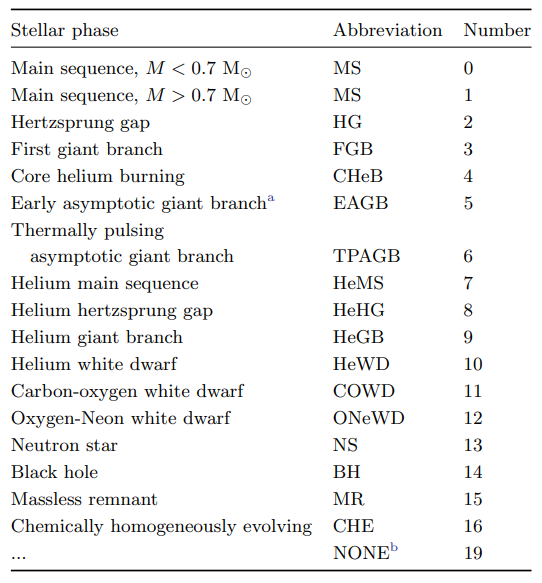

In [7]:
Image("/home/louism/Thesis/COMPAS_stellar_types.png")

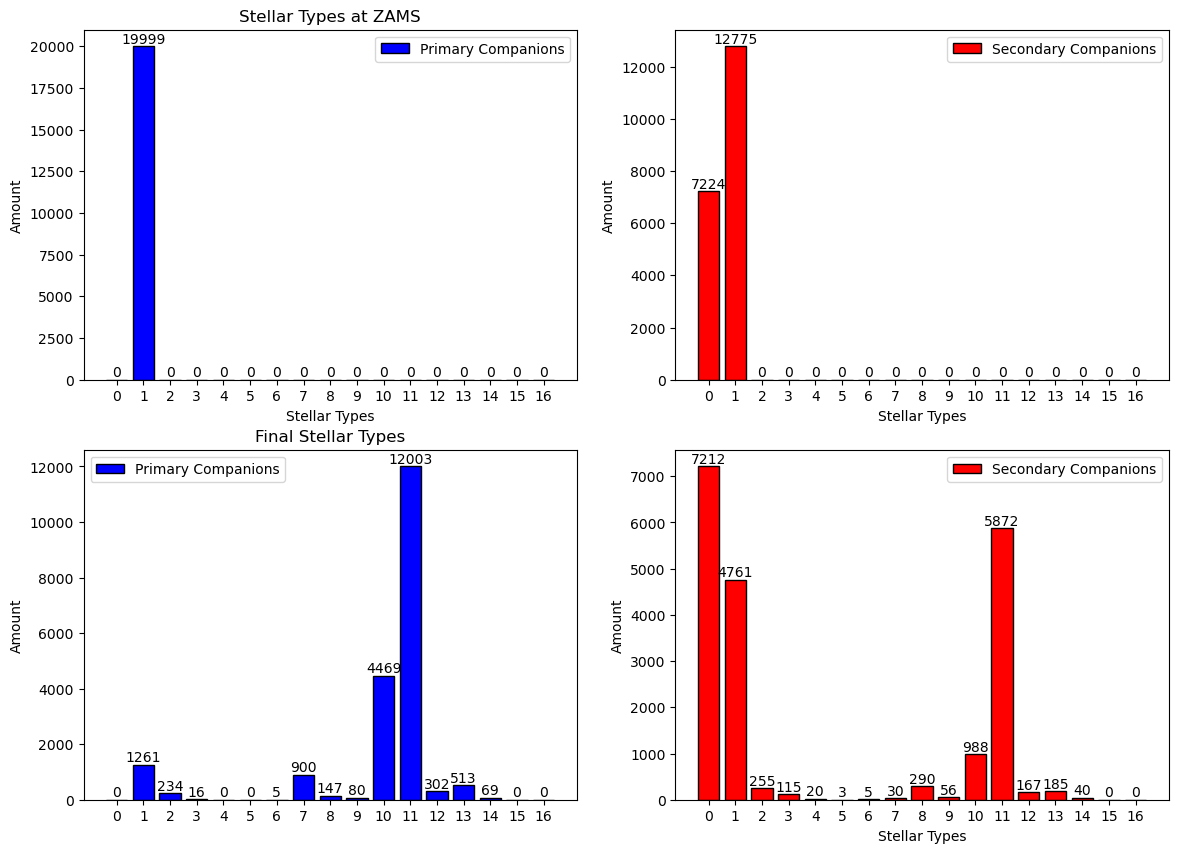

In [8]:
stellar_types_histogram(data)

## Analysis of the different formation channels of sdB binaries

### First CE ejection channel
- Primary (more massive) component experiences dynamical mass transfer on the FGB, leading to CE and spiral-in phase
- Product is an sdB in a short period binary with a MS companion
  
Two subchannels:
1) If the initial mass is below helium flash mass (~1.99 solar mass): primary must fill Roche lobe close to tip of FGB in order to ignite helium. The sdB stars from this channel should have masses just below the ciritical core mass for the helium flash. The mass distribution is peaked around 0.46 solar mass and orbital period distribution ranges from 0.05 to around 40 days.
2) If the inital mass is above the helium flash mass: primary must not be close to tip of FGB and can be passing through HG. Envelopes in HG are tighter bound so systems are more likely to merge rather than form sdB stars.

In [9]:
system_is_bound_mask = (SPs['Unbound'][()] == 0) 
ejected_mask = (SPs['Unbound'][()] == 1)

primary_is_donor_mask = (SPs['MT_Donor_Hist(1)'][()] != b'NA              ')
secondary_is_donor_mask = (SPs['MT_Donor_Hist(2)'][()] != b'NA              ')

primary_below_helium_flash_mask = (SPs['Mass@ZAMS(1)'][()] <= 1.99)
secondary_below_helium_flash_mask = (SPs['Mass@ZAMS(2)'][()] <= 1.99)

primary_above_helium_flash_mask = (SPs['Mass@ZAMS(1)'][()] >= 1.99)
secondary_above_helium_flash_mask = (SPs['Mass@ZAMS(2)'][()] >= 1.99)

primary_CE_on_FGB_mask = np.in1d(SPs['Stellar_Type(1)<CE'][()], [3,4,5,6])
primary_CE_on_HG_FGB_mask = np.in1d(SPs['Stellar_Type(1)<CE'][()], [2,3])
primary_HeMS_after_CE_mask = np.in1d(SPs['Stellar_Type(1)>CE'][()], [7,8,9])  
secondary_CE_on_FGB_mask = np.in1d(SPs['Stellar_Type(2)<CE'][()], [3,4,5,6])
secondary_CE_on_HG_FGB_mask = np.in1d(SPs['Stellar_Type(2)<CE'][()], [2,3])
secondary_HeMS_after_CE_mask = np.in1d(SPs['Stellar_Type(2)>CE'][()], [7,8,9])

primary_companion_is_MS_mask = np.in1d(SPs['Stellar_Type(2)<CE'][()], [0,1,2,3,4,5,6])
secondary_companion_is_MS_mask = np.in1d(SPs['Stellar_Type(1)<CE'][()], [0,1,2,3,4,5,6])

primary_full_lifetime_mask = (SPs['Stellar_Type(1)'][()] >= 7)
secondary_full_lifetime_mask = (SPs['Stellar_Type(2)'][()] >= 7)

primary_firstCE_SubChannel1_bound_mask = (system_is_bound_mask & primary_is_donor_mask & primary_below_helium_flash_mask & 
                                      primary_CE_on_FGB_mask & primary_HeMS_after_CE_mask & primary_companion_is_MS_mask)

secondary_firstCE_SubChannel1_bound_mask = (system_is_bound_mask & primary_is_donor_mask & secondary_below_helium_flash_mask & 
                                      secondary_CE_on_FGB_mask & secondary_HeMS_after_CE_mask & secondary_companion_is_MS_mask)

primary_firstCE_SubChannel2_bound_mask = (system_is_bound_mask & primary_is_donor_mask & primary_above_helium_flash_mask & 
                                      primary_CE_on_HG_FGB_mask & primary_HeMS_after_CE_mask & primary_companion_is_MS_mask)

secondary_firstCE_SubChannel2_bound_mask = (system_is_bound_mask & primary_is_donor_mask & secondary_above_helium_flash_mask & 
                                      secondary_CE_on_HG_FGB_mask & secondary_HeMS_after_CE_mask & secondary_companion_is_MS_mask)

In [10]:
primary_firstCE_SubChannel1_bound_seeds = (SPs['SEED'][primary_firstCE_SubChannel1_bound_mask])

secondary_firstCE_SubChannel1_bound_seeds = (SPs['SEED'][secondary_firstCE_SubChannel1_bound_mask])

primary_firstCE_SubChannel2_bound_seeds = (SPs['SEED'][primary_firstCE_SubChannel2_bound_mask])

secondary_firstCE_SubChannel2_bound_seeds = (SPs['SEED'][secondary_firstCE_SubChannel2_bound_mask])

print('The first subchannel produces', len(primary_firstCE_SubChannel1_bound_seeds)+len(secondary_firstCE_SubChannel1_bound_seeds), 
      'sdB systems. The second subchannel produces', len(primary_firstCE_SubChannel2_bound_seeds)+len(secondary_firstCE_SubChannel2_bound_seeds),
      'sdB systems.')

The first subchannel produces 242 sdB systems. The second subchannel produces 646 sdB systems.


In [11]:
periods_first_CE_subchannel1_1 = (2*np.pi/np.sqrt(G)*
           np.sqrt( (SPs['SemiMajorAxis>CE'][primary_firstCE_SubChannel1_bound_mask])**3 / (SPs['Mass(1)>CE'][primary_firstCE_SubChannel1_bound_mask]+SPs['Mass(2)>CE'][primary_firstCE_SubChannel1_bound_mask]))
          )
periods_first_CE_subchannel1_2 = (2*np.pi/np.sqrt(G)*
           np.sqrt( (SPs['SemiMajorAxis>CE'][secondary_firstCE_SubChannel1_bound_mask])**3 / (SPs['Mass(1)>CE'][secondary_firstCE_SubChannel1_bound_mask]+SPs['Mass(2)>CE'][secondary_firstCE_SubChannel1_bound_mask]))
           )

periods_first_CE_subchannel1 = np.append(periods_first_CE_subchannel1_1, periods_first_CE_subchannel1_2)

masses_firstCE_subchannel1_1 = SPs['Mass(1)>CE'][primary_firstCE_SubChannel1_bound_mask] 
masses_firstCE_subchannel1_2 = SPs['Mass(2)>CE'][secondary_firstCE_SubChannel1_bound_mask]

masses_firstCE_subchannel1 = np.append(masses_firstCE_subchannel1_1, masses_firstCE_subchannel1_2)


period_first_CE_subchannel1_bins = np.linspace(0,45, 46)
period_first_CE_subchannel1_range = np.linspace(0,45, 1000)
kde_periods_first_CE_subchannel1 = gaussian_kde(periods_first_CE_subchannel1)

masses_firstCE_subchannel1_bins = np.linspace(0, (np.max(masses_firstCE_subchannel1)+0.5), 20)
masses_firstCE_subchannel1_range = np.linspace(0, (np.max(masses_firstCE_subchannel1)+0.5), 1000)
kde_masses_firstCE_subchannel1 = gaussian_kde(masses_firstCE_subchannel1)

In [12]:
periods_first_CE_subchannel2_1 = (2*np.pi/np.sqrt(G)*
           np.sqrt( (SPs['SemiMajorAxis>CE'][primary_firstCE_SubChannel2_bound_mask])**3 / (SPs['Mass(1)>CE'][primary_firstCE_SubChannel2_bound_mask]+SPs['Mass(2)>CE'][primary_firstCE_SubChannel2_bound_mask]))
          )
periods_first_CE_subchannel2_2 = (2*np.pi/np.sqrt(G)*
           np.sqrt( (SPs['SemiMajorAxis>CE'][secondary_firstCE_SubChannel2_bound_mask])**3 / (SPs['Mass(1)>CE'][secondary_firstCE_SubChannel2_bound_mask]+SPs['Mass(2)>CE'][secondary_firstCE_SubChannel2_bound_mask]))
           )

periods_first_CE_subchannel2 = np.append(periods_first_CE_subchannel2_1, periods_first_CE_subchannel2_2)

masses_firstCE_subchannel2_1 = SPs['Mass(1)>CE'][primary_firstCE_SubChannel2_bound_mask] 
masses_firstCE_subchannel2_2 = SPs['Mass(2)>CE'][secondary_firstCE_SubChannel2_bound_mask]

masses_firstCE_subchannel2 = np.append(masses_firstCE_subchannel2_1, masses_firstCE_subchannel2_2)


period_first_CE_subchannel2_bins = np.linspace(0,5, 21)
period_first_CE_subchannel2_range = np.linspace(0,5, 1000)
kde_periods_first_CE_subchannel2 = gaussian_kde(periods_first_CE_subchannel2)

masses_firstCE_subchannel2_bins = np.linspace(0, (np.max(masses_firstCE_subchannel2)+0.5), 20)
masses_firstCE_subchannel2_range = np.linspace(0, (np.max(masses_firstCE_subchannel2)+0.5), 1000)
kde_masses_firstCE_subchannel2 = gaussian_kde(masses_firstCE_subchannel2)

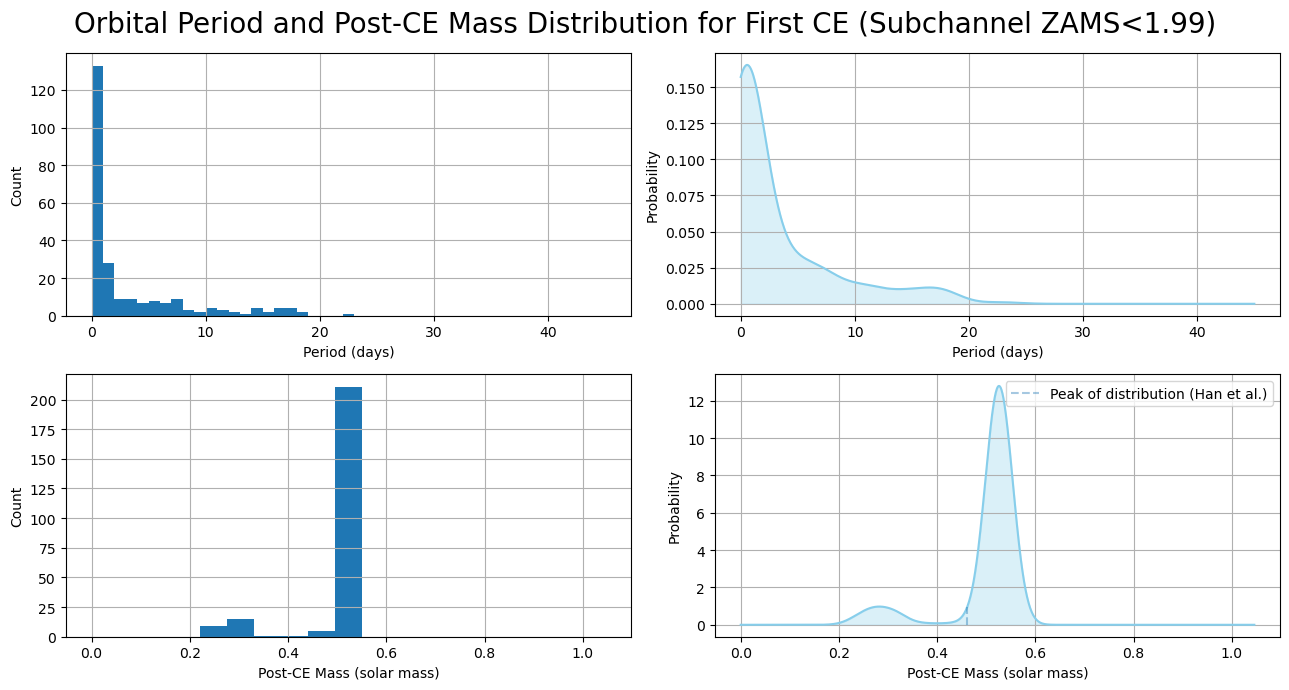

In [13]:
fig, ax = plt.subplots(2,2, figsize=(13,7))

ax[0][0].hist(periods_first_CE_subchannel1, period_first_CE_subchannel1_bins)
ax[0][0].set_xlabel('Period (days)')
ax[0][0].set_ylabel('Count')
ax[0][0].grid()

ax[0][1].plot(period_first_CE_subchannel1_range, kde_periods_first_CE_subchannel1(period_first_CE_subchannel1_range), color='skyblue')
ax[0][1].fill_between(period_first_CE_subchannel1_range, kde_periods_first_CE_subchannel1(period_first_CE_subchannel1_range), color='skyblue', alpha=0.3)
ax[0][1].set_xlabel('Period (days)')
ax[0][1].set_ylabel('Probability')
ax[0][1].grid()

ax[1][0].hist(masses_firstCE_subchannel1, masses_firstCE_subchannel1_bins)
ax[1][0].set_xlabel('Post-CE Mass (solar mass)')
ax[1][0].set_ylabel('Count')
ax[1][0].grid()

ax[1][1].plot(masses_firstCE_subchannel1_range, kde_masses_firstCE_subchannel1(masses_firstCE_subchannel1_range), color='skyblue')
ax[1][1].fill_between(masses_firstCE_subchannel1_range, kde_masses_firstCE_subchannel1(masses_firstCE_subchannel1_range), color='skyblue', alpha=0.3)
ax[1][1].vlines(0.46, 0, 0.95, linestyle='--', alpha=0.4, label='Peak of distribution (Han et al.)')
ax[1][1].set_xlabel('Post-CE Mass (solar mass)')
ax[1][1].set_ylabel('Probability')
ax[1][1].grid()
ax[1][1].legend()

fig.suptitle('Orbital Period and Post-CE Mass Distribution for First CE (Subchannel ZAMS<1.99)', fontsize=20) 
fig.tight_layout()


- period distribution in agreement with paper
- mass distribution should peak at 0.46
- credibility of Stellar_Type>CE and <CE, assumed more stellar types than paper 

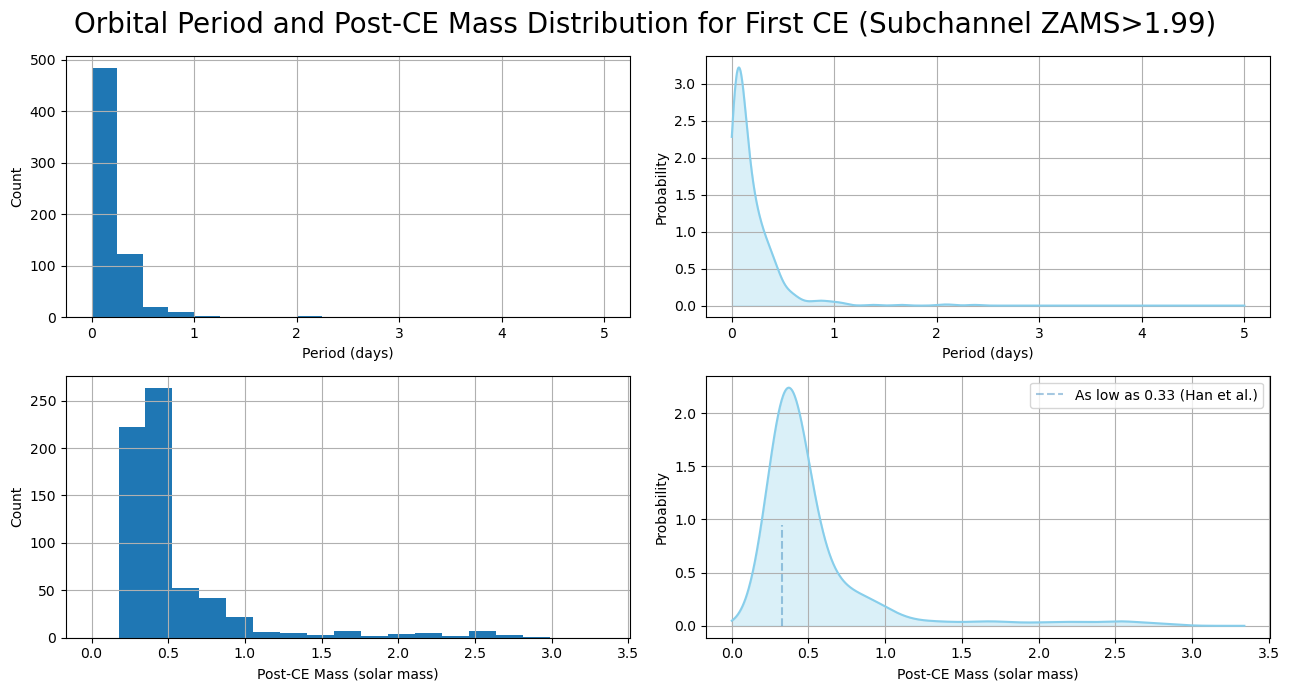

In [14]:
fig, ax = plt.subplots(2,2, figsize=(13,7))

ax[0][0].hist(periods_first_CE_subchannel2, period_first_CE_subchannel2_bins)
ax[0][0].set_xlabel('Period (days)')
ax[0][0].set_ylabel('Count')
ax[0][0].grid()

ax[0][1].plot(period_first_CE_subchannel2_range, kde_periods_first_CE_subchannel2(period_first_CE_subchannel2_range), color='skyblue')
ax[0][1].fill_between(period_first_CE_subchannel2_range, kde_periods_first_CE_subchannel2(period_first_CE_subchannel2_range), color='skyblue', alpha=0.3)
ax[0][1].set_xlabel('Period (days)')
ax[0][1].set_ylabel('Probability')
ax[0][1].grid()

ax[1][0].hist(masses_firstCE_subchannel2, masses_firstCE_subchannel2_bins)
ax[1][0].set_xlabel('Post-CE Mass (solar mass)')
ax[1][0].set_ylabel('Count')
ax[1][0].grid()

ax[1][1].plot(masses_firstCE_subchannel2_range, kde_masses_firstCE_subchannel2(masses_firstCE_subchannel2_range), color='skyblue')
ax[1][1].fill_between(masses_firstCE_subchannel2_range, kde_masses_firstCE_subchannel2(masses_firstCE_subchannel2_range), color='skyblue', alpha=0.3)
ax[1][1].vlines(0.33, 0, 0.95, linestyle='--', alpha=0.4, label='As low as 0.33 (Han et al.)')
ax[1][1].set_xlabel('Post-CE Mass (solar mass)')
ax[1][1].set_ylabel('Probability')
ax[1][1].grid()
ax[1][1].legend()

fig.suptitle('Orbital Period and Post-CE Mass Distribution for First CE (Subchannel ZAMS>1.99)', fontsize=20) 
fig.tight_layout()


- extremely low periods in agreement with merger assumption from paper
- mass distribution in agreement and lower limit of 0.33 present as well
- (too) high amount of systems?
- credibility CE['Merger'][()]?

### Second CE ejection channel
- Companion to Giant is now already an WD, leading to shorter orbital periods but also a wider range of orbital periods
- Agian two subchannels depending on masses but now in the second subchannel a merger can be more easily avoided

In [15]:
primary_companion_is_WD_mask = np.in1d(SPs['Stellar_Type(2)<CE'][()], [10,11,12])
secondary_companion_is_WD_mask = np.in1d(SPs['Stellar_Type(1)<CE'][()], [10,11,12])

In [16]:
primary_secondCE_SubChannel1_bound_mask = (system_is_bound_mask & primary_is_donor_mask & primary_below_helium_flash_mask & 
                                      primary_CE_on_FGB_mask & primary_HeMS_after_CE_mask & primary_companion_is_WD_mask)

secondary_secondCE_SubChannel1_bound_mask = (system_is_bound_mask & primary_is_donor_mask & secondary_below_helium_flash_mask & 
                                      secondary_CE_on_FGB_mask & secondary_HeMS_after_CE_mask & secondary_companion_is_WD_mask)

primary_secondCE_SubChannel2_bound_mask = (system_is_bound_mask & primary_is_donor_mask & primary_above_helium_flash_mask & 
                                      primary_CE_on_HG_FGB_mask & primary_HeMS_after_CE_mask & primary_companion_is_WD_mask)

secondary_secondCE_SubChannel2_bound_mask = (system_is_bound_mask & primary_is_donor_mask & secondary_above_helium_flash_mask & 
                                      secondary_CE_on_HG_FGB_mask & secondary_HeMS_after_CE_mask & secondary_companion_is_WD_mask)

In [17]:
primary_secondCE_SubChannel1_bound_seeds = (SPs['SEED'][primary_secondCE_SubChannel1_bound_mask])

secondary_secondCE_SubChannel1_bound_seeds = (SPs['SEED'][secondary_secondCE_SubChannel1_bound_mask])

primary_secondCE_SubChannel2_bound_seeds = (SPs['SEED'][primary_secondCE_SubChannel2_bound_mask])

secondary_secondCE_SubChannel2_bound_seeds = (SPs['SEED'][secondary_secondCE_SubChannel2_bound_mask])

print('The first subchannel produces', len(primary_secondCE_SubChannel1_bound_seeds)+len(secondary_secondCE_SubChannel1_bound_seeds), 
      'sdB systems. The second subchannel produces', len(primary_secondCE_SubChannel2_bound_seeds)+len(secondary_secondCE_SubChannel2_bound_seeds),
      'sdB systems.')

The first subchannel produces 395 sdB systems. The second subchannel produces 108 sdB systems.


In [18]:
periods_second_CE_subchannel1_1 = (2*np.pi/np.sqrt(G)*
           np.sqrt( (SPs['SemiMajorAxis>CE'][primary_secondCE_SubChannel1_bound_mask])**3 / (SPs['Mass(1)>CE'][primary_secondCE_SubChannel1_bound_mask]+SPs['Mass(2)>CE'][primary_secondCE_SubChannel1_bound_mask]))
          )
periods_second_CE_subchannel1_2 = (2*np.pi/np.sqrt(G)*
           np.sqrt( (SPs['SemiMajorAxis>CE'][secondary_secondCE_SubChannel1_bound_mask])**3 / (SPs['Mass(1)>CE'][secondary_secondCE_SubChannel1_bound_mask]+SPs['Mass(2)>CE'][secondary_secondCE_SubChannel1_bound_mask]))
           )

periods_second_CE_subchannel1 = np.append(periods_second_CE_subchannel1_1, periods_second_CE_subchannel1_2)

masses_secondCE_subchannel1_1 = SPs['Mass(1)>CE'][primary_secondCE_SubChannel1_bound_mask] 
masses_secondCE_subchannel1_2 = SPs['Mass(2)>CE'][secondary_secondCE_SubChannel1_bound_mask]

masses_secondCE_subchannel1 = np.append(masses_secondCE_subchannel1_1, masses_secondCE_subchannel1_2)


period_second_CE_subchannel1_bins = np.linspace(0,45, 46)
period_second_CE_subchannel1_range = np.linspace(0,45, 1000)
kde_periods_second_CE_subchannel1 = gaussian_kde(periods_second_CE_subchannel1)

masses_secondCE_subchannel1_bins = np.linspace(0, (np.max(masses_secondCE_subchannel1)+0.5), 20)
masses_secondCE_subchannel1_range = np.linspace(0, (np.max(masses_secondCE_subchannel1)+0.5), 1000)
kde_masses_secondCE_subchannel1 = gaussian_kde(masses_secondCE_subchannel1)

In [19]:
periods_second_CE_subchannel2_1 = (2*np.pi/np.sqrt(G)*
           np.sqrt( (SPs['SemiMajorAxis>CE'][primary_secondCE_SubChannel2_bound_mask])**3 / (SPs['Mass(1)>CE'][primary_secondCE_SubChannel2_bound_mask]+SPs['Mass(2)>CE'][primary_secondCE_SubChannel2_bound_mask]))
          )
periods_second_CE_subchannel2_2 = (2*np.pi/np.sqrt(G)*
           np.sqrt( (SPs['SemiMajorAxis>CE'][secondary_secondCE_SubChannel2_bound_mask])**3 / (SPs['Mass(1)>CE'][secondary_secondCE_SubChannel2_bound_mask]+SPs['Mass(2)>CE'][secondary_secondCE_SubChannel2_bound_mask]))
           )

periods_second_CE_subchannel2 = np.append(periods_second_CE_subchannel2_1, periods_second_CE_subchannel2_2)

masses_secondCE_subchannel2_1 = SPs['Mass(1)>CE'][primary_secondCE_SubChannel2_bound_mask] 
masses_secondCE_subchannel2_2 = SPs['Mass(2)>CE'][secondary_secondCE_SubChannel2_bound_mask]

masses_secondCE_subchannel2 = np.append(masses_secondCE_subchannel2_1, masses_secondCE_subchannel2_2)


period_second_CE_subchannel2_bins = np.linspace(0,5, 21)
period_second_CE_subchannel2_range = np.linspace(0,5, 1000)
kde_periods_second_CE_subchannel2 = gaussian_kde(periods_second_CE_subchannel2)

masses_secondCE_subchannel2_bins = np.linspace(0, (np.max(masses_secondCE_subchannel2)+0.5), 20)
masses_secondCE_subchannel2_range = np.linspace(0, (np.max(masses_secondCE_subchannel2)+0.5), 1000)
kde_masses_secondCE_subchannel2 = gaussian_kde(masses_secondCE_subchannel2)

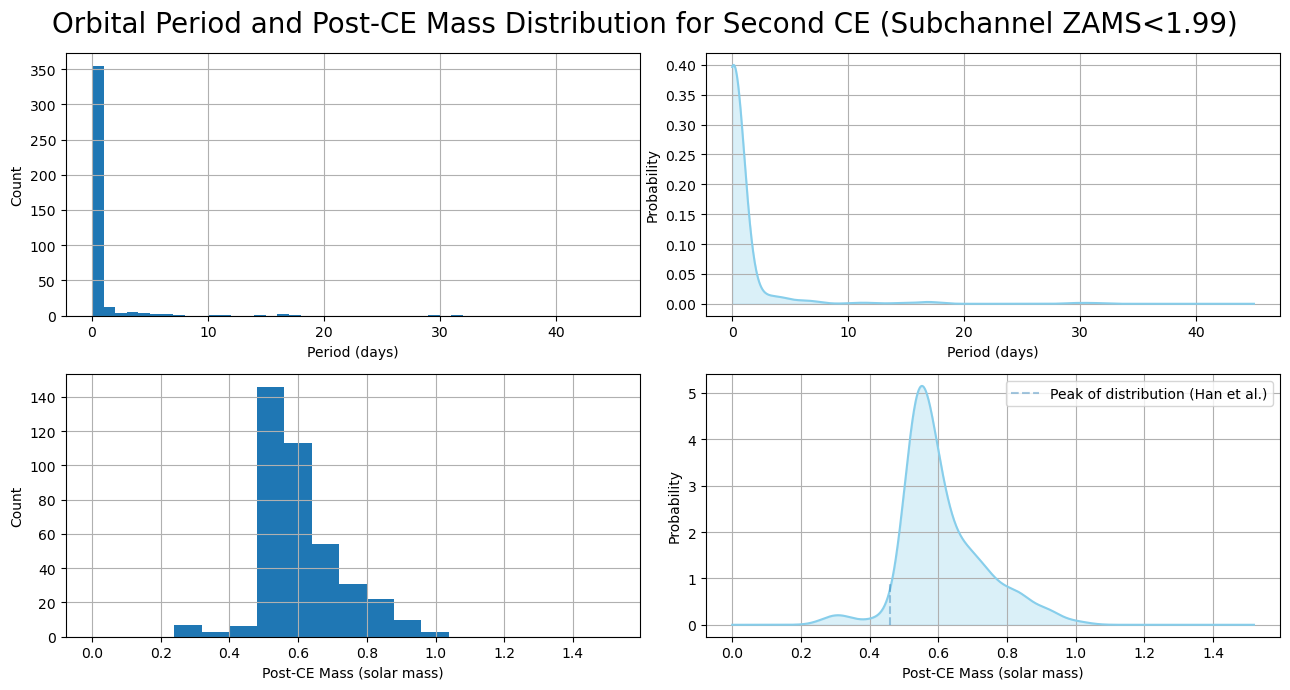

In [20]:
fig, ax = plt.subplots(2,2, figsize=(13,7))

ax[0][0].hist(periods_second_CE_subchannel1, period_second_CE_subchannel1_bins)
ax[0][0].set_xlabel('Period (days)')
ax[0][0].set_ylabel('Count')
ax[0][0].grid()

ax[0][1].plot(period_second_CE_subchannel1_range, kde_periods_second_CE_subchannel1(period_second_CE_subchannel1_range), color='skyblue')
ax[0][1].fill_between(period_second_CE_subchannel1_range, kde_periods_second_CE_subchannel1(period_second_CE_subchannel1_range), color='skyblue', alpha=0.3)
ax[0][1].set_xlabel('Period (days)')
ax[0][1].set_ylabel('Probability')
ax[0][1].grid()

ax[1][0].hist(masses_secondCE_subchannel1, masses_secondCE_subchannel1_bins)
ax[1][0].set_xlabel('Post-CE Mass (solar mass)')
ax[1][0].set_ylabel('Count')
ax[1][0].grid()

ax[1][1].plot(masses_secondCE_subchannel1_range, kde_masses_secondCE_subchannel1(masses_secondCE_subchannel1_range), color='skyblue')
ax[1][1].fill_between(masses_secondCE_subchannel1_range, kde_masses_secondCE_subchannel1(masses_secondCE_subchannel1_range), color='skyblue', alpha=0.3)
ax[1][1].vlines(0.46, 0, 0.95, linestyle='--', alpha=0.4, label='Peak of distribution (Han et al.)')
ax[1][1].set_xlabel('Post-CE Mass (solar mass)')
ax[1][1].set_ylabel('Probability')
ax[1][1].grid()
ax[1][1].legend()

fig.suptitle('Orbital Period and Post-CE Mass Distribution for Second CE (Subchannel ZAMS<1.99)', fontsize=20) 
fig.tight_layout()

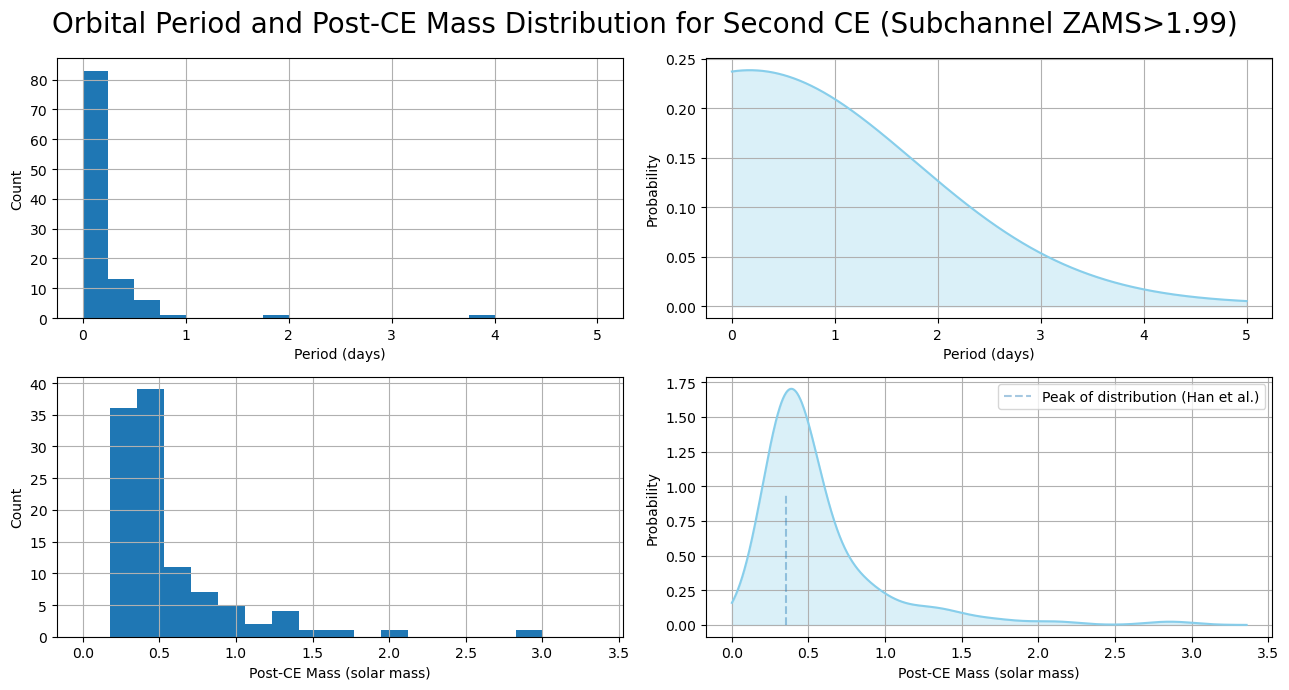

In [21]:
fig, ax = plt.subplots(2,2, figsize=(13,7))

ax[0][0].hist(periods_second_CE_subchannel2, period_second_CE_subchannel2_bins)
ax[0][0].set_xlabel('Period (days)')
ax[0][0].set_ylabel('Count')
ax[0][0].grid()

ax[0][1].plot(period_second_CE_subchannel2_range, kde_periods_second_CE_subchannel2(period_second_CE_subchannel2_range), color='skyblue')
ax[0][1].fill_between(period_second_CE_subchannel2_range, kde_periods_second_CE_subchannel2(period_second_CE_subchannel2_range), color='skyblue', alpha=0.3)
ax[0][1].set_xlabel('Period (days)')
ax[0][1].set_ylabel('Probability')
ax[0][1].grid()

ax[1][0].hist(masses_secondCE_subchannel2, masses_secondCE_subchannel2_bins)
ax[1][0].set_xlabel('Post-CE Mass (solar mass)')
ax[1][0].set_ylabel('Count')
ax[1][0].grid()

ax[1][1].plot(masses_secondCE_subchannel2_range, kde_masses_secondCE_subchannel2(masses_secondCE_subchannel2_range), color='skyblue')
ax[1][1].fill_between(masses_secondCE_subchannel2_range, kde_masses_secondCE_subchannel2(masses_secondCE_subchannel2_range), color='skyblue', alpha=0.3)
ax[1][1].vlines(0.35, 0, 0.95, linestyle='--', alpha=0.4, label='Peak of distribution (Han et al.)')
ax[1][1].set_xlabel('Post-CE Mass (solar mass)')
ax[1][1].set_ylabel('Probability')
ax[1][1].grid()
ax[1][1].legend()

fig.suptitle('Orbital Period and Post-CE Mass Distribution for Second CE (Subchannel ZAMS>1.99)', fontsize=20) 
fig.tight_layout()

### First stable RLOF channel
- Primary (more massive) component experiences stable mass transfer and loses envelope
- Shortest orbital periods are the result from angular momentum loss
- Wider mass range from 0.3-1.1 solar mass

Two subchannels
1) ZAMS mass above helium flash mass, RLOF near tip of FGB
2) ZAMS mass below helium flash mass, RLOF can occur in HG (early case B MT)
Wider mass range from 0.3-1.1 solar mass

In [22]:
not_in_CE_channels_mask = np.in1d(RLOF['SEED'][()], CEs['SEED'][()], invert=True)

primary_RLOF_on_FGB_mask = np.in1d(RLOF['Stellar_Type(1)<MT'][()], [3,4,5,6])
secondary_RLOF_on_FGB_mask = np.in1d(RLOF['Stellar_Type(2)<MT'][()], [3,4,5,6])

primary_RLOF_on_HG_FGB_mask = np.in1d(RLOF['Stellar_Type(1)<MT'][()], [2,3])
secondary_RLOF_on_HG_FGB_mask = np.in1d(RLOF['Stellar_Type(2)<MT'][()], [2,3])

primary_HeMS_after_RLOF_mask = np.in1d(RLOF['Stellar_Type(1)>MT'][()], [7,8,9])
secondary_HeMS_after_RLOF_mask = np.in1d(RLOF['Stellar_Type(2)>MT'][()], [7,8,9])

primary_companion_is_MS_mask = np.in1d(RLOF['Stellar_Type(2)>MT'][()], [0,1,2,3,4,5,6]) 
secondary_companion_is_MS_mask = np.in1d(RLOF['Stellar_Type(1)>MT'][()], [0,1,2,3,4,5,6])

primary_companion_is_WD_mask = np.in1d(RLOF['Stellar_Type(2)>MT'][()], [10,11,12]) 
secondary_companion_is_WD_mask = np.in1d(RLOF['Stellar_Type(1)>MT'][()], [10,11,12])


###########################################################################################################################################################

primary_firstRLOF_Subchannel1_bound_sp_mask = (system_is_bound_mask & primary_is_donor_mask & 
                                               primary_below_helium_flash_mask
                                              )
secondary_firstRLOF_Subchannel1_bound_sp_mask = (system_is_bound_mask & secondary_is_donor_mask & 
                                               secondary_below_helium_flash_mask
                                              )
                                               
primary_firstRLOF_Subchannel1_bound_rlof_mask = (not_in_CE_channels_mask & primary_RLOF_on_FGB_mask &
                                                 primary_HeMS_after_RLOF_mask & primary_companion_is_MS_mask
                                                )
secondary_firstRLOF_Subchannel1_bound_rlof_mask = (not_in_CE_channels_mask & secondary_RLOF_on_FGB_mask &
                                                 secondary_HeMS_after_RLOF_mask & secondary_companion_is_MS_mask
                                                )
###########################################################################################################################################################
primary_firstRLOF_Subchannel2_bound_sp_mask = (system_is_bound_mask & primary_is_donor_mask & 
                                               primary_above_helium_flash_mask
                                              )
secondary_firstRLOF_Subchannel2_bound_sp_mask = (system_is_bound_mask & secondary_is_donor_mask & 
                                               secondary_above_helium_flash_mask
                                              )
                                               
primary_firstRLOF_Subchannel2_bound_rlof_mask = (not_in_CE_channels_mask & primary_RLOF_on_HG_FGB_mask &
                                                 primary_HeMS_after_RLOF_mask & primary_companion_is_MS_mask
                                                )
secondary_firstRLOF_Subchannel2_bound_rlof_mask = (not_in_CE_channels_mask & secondary_RLOF_on_HG_FGB_mask &
                                                 secondary_HeMS_after_RLOF_mask & secondary_companion_is_MS_mask
                                                )

In [23]:
primary_firstRLOF_Subchannel1_bound_seeds = np.intersect1d(SPs['SEED'][primary_firstRLOF_Subchannel1_bound_sp_mask],
                                                           RLOF['SEED'][primary_firstRLOF_Subchannel1_bound_rlof_mask])
primary_firstRLOF_Subchannel1_bound_full_sp_mask = np.in1d(SPs['SEED'][()], primary_firstRLOF_Subchannel1_bound_seeds)
primary_firstRLOF_Subchannel1_bound_full_rlof_mask = np.in1d(RLOF['SEED'][()], primary_firstRLOF_Subchannel1_bound_seeds)

secondary_firstRLOF_Subchannel1_bound_seeds = np.intersect1d(SPs['SEED'][secondary_firstRLOF_Subchannel1_bound_sp_mask],
                                                           RLOF['SEED'][secondary_firstRLOF_Subchannel1_bound_rlof_mask])
secondary_firstRLOF_Subchannel1_bound_full_sp_mask = np.in1d(SPs['SEED'][()], secondary_firstRLOF_Subchannel1_bound_seeds)
secondary_firstRLOF_Subchannel1_bound_full_rlof_mask = np.in1d(RLOF['SEED'][()], secondary_firstRLOF_Subchannel1_bound_seeds)
###########################################################################################################################################################
primary_firstRLOF_Subchannel2_bound_seeds = np.intersect1d(SPs['SEED'][primary_firstRLOF_Subchannel2_bound_sp_mask],
                                                           RLOF['SEED'][primary_firstRLOF_Subchannel2_bound_rlof_mask])
primary_firstRLOF_Subchannel2_bound_full_sp_mask = np.in1d(SPs['SEED'][()], primary_firstRLOF_Subchannel2_bound_seeds)
primary_firstRLOF_Subchannel2_bound_full_rlof_mask = np.in1d(RLOF['SEED'][()], primary_firstRLOF_Subchannel2_bound_seeds)

secondary_firstRLOF_Subchannel2_bound_seeds = np.intersect1d(SPs['SEED'][secondary_firstRLOF_Subchannel2_bound_sp_mask],
                                                           RLOF['SEED'][secondary_firstRLOF_Subchannel2_bound_rlof_mask])
secondary_firstRLOF_Subchannel2_bound_full_sp_mask = np.in1d(SPs['SEED'][()], secondary_firstRLOF_Subchannel2_bound_seeds)
secondary_firstRLOF_Subchannel2_bound_full_rlof_mask = np.in1d(RLOF['SEED'][()], secondary_firstRLOF_Subchannel2_bound_seeds)

In [24]:
print('The first subchannel produces', len(primary_firstRLOF_Subchannel1_bound_seeds)+len(secondary_firstRLOF_Subchannel1_bound_seeds), 
      'sdB systems. The second subchannel produces', len(primary_firstRLOF_Subchannel2_bound_seeds)+len(secondary_firstRLOF_Subchannel2_bound_seeds) ,
      'sdB systems')

The first subchannel produces 143 sdB systems. The second subchannel produces 58 sdB systems


In [25]:
periods_first_RLOF_subchannel1_1 = (2*np.pi/np.sqrt(G)*
           np.sqrt( (RLOF['SemiMajorAxis>MT'][primary_firstRLOF_Subchannel1_bound_full_rlof_mask])**3 / (RLOF['Mass(1)>MT'][primary_firstRLOF_Subchannel1_bound_full_rlof_mask]+RLOF['Mass(2)>MT'][primary_firstRLOF_Subchannel1_bound_full_rlof_mask]))
          )
periods_first_RLOF_subchannel1_2 = (2*np.pi/np.sqrt(G)*
           np.sqrt( (RLOF['SemiMajorAxis>MT'][secondary_firstRLOF_Subchannel1_bound_full_rlof_mask])**3 / (RLOF['Mass(1)>MT'][secondary_firstRLOF_Subchannel1_bound_full_rlof_mask]+RLOF['Mass(2)>MT'][secondary_firstRLOF_Subchannel1_bound_full_rlof_mask]))
           )

periods_first_RLOF_subchannel1 = np.append(periods_first_RLOF_subchannel1_1, periods_first_RLOF_subchannel1_2)

masses_firstRLOF_subchannel1_1 = RLOF['Mass(1)>MT'][primary_firstRLOF_Subchannel1_bound_full_rlof_mask] 
masses_firstRLOF_subchannel1_2 = RLOF['Mass(2)>MT'][secondary_firstRLOF_Subchannel1_bound_full_rlof_mask]

masses_firstRLOF_subchannel1 = np.append(masses_firstRLOF_subchannel1_1, masses_firstRLOF_subchannel1_2)


period_first_RLOF_subchannel1_bins = np.linspace(0,7000, 50)
period_first_RLOF_subchannel1_range = np.linspace(0,7000, 10000)
kde_periods_first_RLOF_subchannel1 = gaussian_kde(periods_first_RLOF_subchannel1)

masses_firstRLOF_subchannel1_bins = np.linspace(0, (np.max(masses_firstRLOF_subchannel1)+0.5), 20)
masses_firstRLOF_subchannel1_range = np.linspace(0, (np.max(masses_firstRLOF_subchannel1)+0.5), 1000)
kde_masses_firstRLOF_subchannel1 = gaussian_kde(masses_firstRLOF_subchannel1)

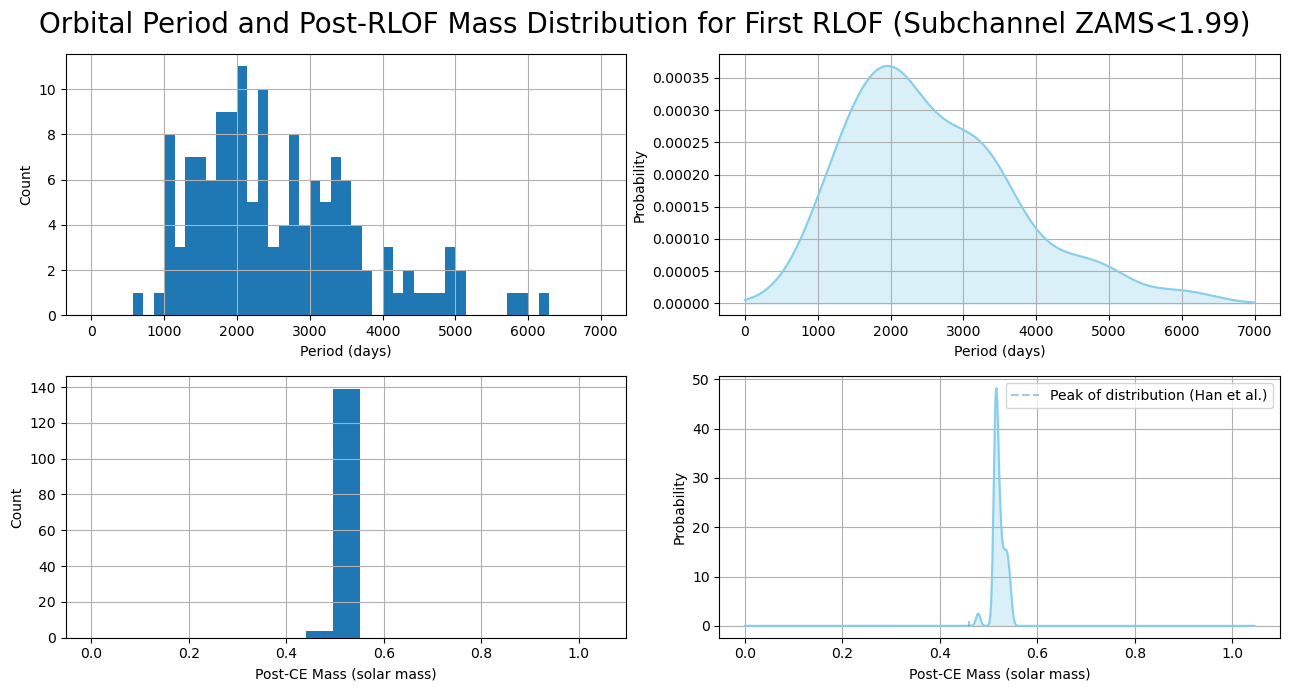

In [26]:
fig, ax = plt.subplots(2,2, figsize=(13,7))

ax[0][0].hist(periods_first_RLOF_subchannel1, period_first_RLOF_subchannel1_bins)
ax[0][0].set_xlabel('Period (days)')
ax[0][0].set_ylabel('Count')
ax[0][0].grid()

ax[0][1].plot(period_first_RLOF_subchannel1_range, kde_periods_first_RLOF_subchannel1(period_first_RLOF_subchannel1_range), color='skyblue')
ax[0][1].fill_between(period_first_RLOF_subchannel1_range, kde_periods_first_RLOF_subchannel1(period_first_RLOF_subchannel1_range), color='skyblue', alpha=0.3)
ax[0][1].set_xlabel('Period (days)')
ax[0][1].set_ylabel('Probability')
ax[0][1].grid()

ax[1][0].hist(masses_firstRLOF_subchannel1, masses_firstRLOF_subchannel1_bins)
ax[1][0].set_xlabel('Post-CE Mass (solar mass)')
ax[1][0].set_ylabel('Count')
ax[1][0].grid()

ax[1][1].plot(masses_firstRLOF_subchannel1_range, kde_masses_firstRLOF_subchannel1(masses_firstRLOF_subchannel1_range), color='skyblue')
ax[1][1].fill_between(masses_firstRLOF_subchannel1_range, kde_masses_firstRLOF_subchannel1(masses_firstRLOF_subchannel1_range), color='skyblue', alpha=0.3)
ax[1][1].vlines(0.46, 0, 0.95, linestyle='--', alpha=0.4, label='Peak of distribution (Han et al.)')
ax[1][1].set_xlabel('Post-CE Mass (solar mass)')
ax[1][1].set_ylabel('Probability')
ax[1][1].grid()
ax[1][1].legend()

fig.suptitle('Orbital Period and Post-RLOF Mass Distribution for First RLOF (Subchannel ZAMS<1.99)', fontsize=20) 
fig.tight_layout()


In [27]:
periods_first_RLOF_subchannel2_1 = (2*np.pi/np.sqrt(G)*
           np.sqrt( (RLOF['SemiMajorAxis>MT'][primary_firstRLOF_Subchannel2_bound_full_rlof_mask])**3 / (RLOF['Mass(1)>MT'][primary_firstRLOF_Subchannel2_bound_full_rlof_mask]+RLOF['Mass(2)>MT'][primary_firstRLOF_Subchannel2_bound_full_rlof_mask]))
          )
periods_first_RLOF_subchannel2_2 = (2*np.pi/np.sqrt(G)*
           np.sqrt( (RLOF['SemiMajorAxis>MT'][secondary_firstRLOF_Subchannel2_bound_full_rlof_mask])**3 / (RLOF['Mass(1)>MT'][secondary_firstRLOF_Subchannel2_bound_full_rlof_mask]+RLOF['Mass(2)>MT'][secondary_firstRLOF_Subchannel2_bound_full_rlof_mask]))
           )

periods_first_RLOF_subchannel2 = np.append(periods_first_RLOF_subchannel2_1, periods_first_RLOF_subchannel2_2)

masses_firstRLOF_subchannel2_1 = RLOF['Mass(1)>MT'][primary_firstRLOF_Subchannel2_bound_full_rlof_mask] 
masses_firstRLOF_subchannel2_2 = RLOF['Mass(2)>MT'][secondary_firstRLOF_Subchannel2_bound_full_rlof_mask]

masses_firstRLOF_subchannel2 = np.append(masses_firstRLOF_subchannel2_1, masses_firstRLOF_subchannel2_2)


period_first_RLOF_subchannel2_bins = np.linspace(0,7000, 50)
period_first_RLOF_subchannel2_range = np.linspace(0,7000, 10000)
kde_periods_first_RLOF_subchannel2 = gaussian_kde(periods_first_RLOF_subchannel2)

masses_firstRLOF_subchannel2_bins = np.linspace(0, (np.max(masses_firstRLOF_subchannel2)+0.5), 20)
masses_firstRLOF_subchannel2_range = np.linspace(0, (np.max(masses_firstRLOF_subchannel2)+0.5), 1000)
kde_masses_firstRLOF_subchannel2 = gaussian_kde(masses_firstRLOF_subchannel2)

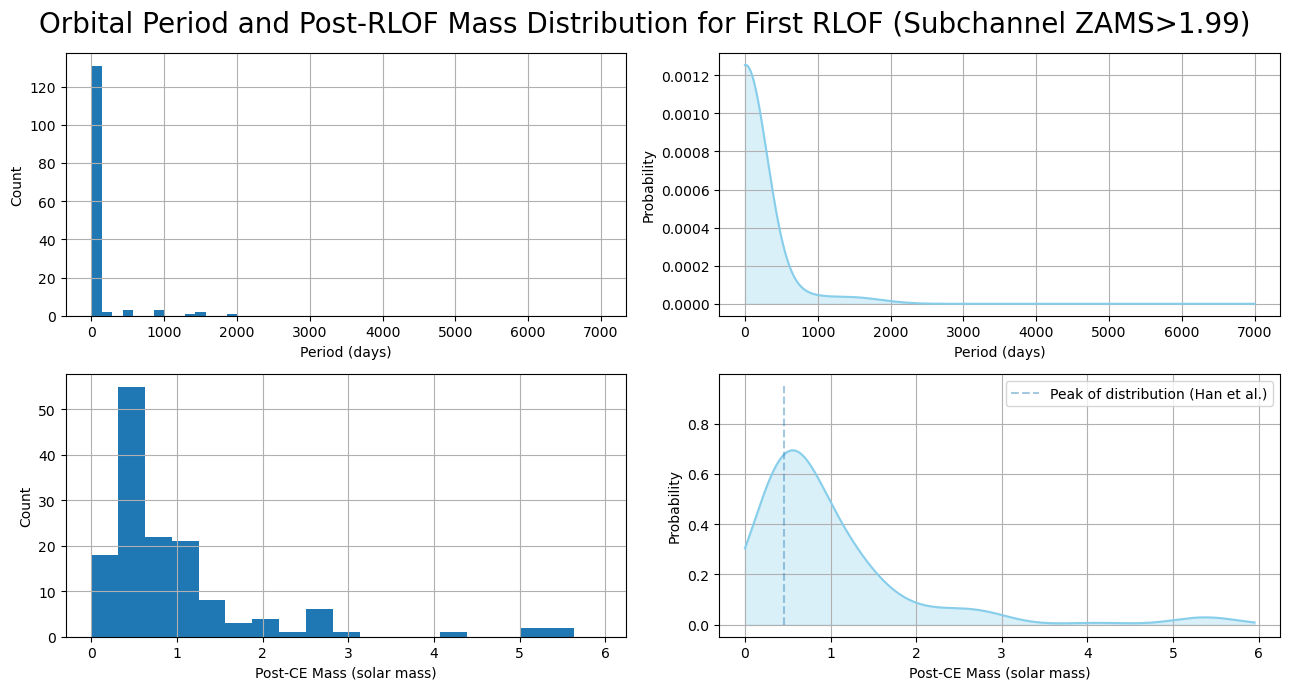

In [28]:
fig, ax = plt.subplots(2,2, figsize=(13,7))

ax[0][0].hist(periods_first_RLOF_subchannel2, period_first_RLOF_subchannel2_bins)
ax[0][0].set_xlabel('Period (days)')
ax[0][0].set_ylabel('Count')
ax[0][0].grid()

ax[0][1].plot(period_first_RLOF_subchannel2_range, kde_periods_first_RLOF_subchannel2(period_first_RLOF_subchannel2_range), color='skyblue')
ax[0][1].fill_between(period_first_RLOF_subchannel2_range, kde_periods_first_RLOF_subchannel2(period_first_RLOF_subchannel2_range), color='skyblue', alpha=0.3)
ax[0][1].set_xlabel('Period (days)')
ax[0][1].set_ylabel('Probability')
ax[0][1].grid()

ax[1][0].hist(masses_firstRLOF_subchannel2, masses_firstRLOF_subchannel2_bins)
ax[1][0].set_xlabel('Post-CE Mass (solar mass)')
ax[1][0].set_ylabel('Count')
ax[1][0].grid()

ax[1][1].plot(masses_firstRLOF_subchannel2_range, kde_masses_firstRLOF_subchannel2(masses_firstRLOF_subchannel2_range), color='skyblue')
ax[1][1].fill_between(masses_firstRLOF_subchannel2_range, kde_masses_firstRLOF_subchannel2(masses_firstRLOF_subchannel2_range), color='skyblue', alpha=0.3)
ax[1][1].vlines(0.46, 0, 0.95, linestyle='--', alpha=0.4, label='Peak of distribution (Han et al.)')
ax[1][1].set_xlabel('Post-CE Mass (solar mass)')
ax[1][1].set_ylabel('Probability')
ax[1][1].grid()
ax[1][1].legend()

fig.suptitle('Orbital Period and Post-RLOF Mass Distribution for First RLOF (Subchannel ZAMS>1.99)', fontsize=20) 
fig.tight_layout()


### Second stable RLOF channel

In [29]:
primary_secondRLOF_Subchannel1_bound_sp_mask = (system_is_bound_mask & primary_is_donor_mask & 
                                               primary_below_helium_flash_mask
                                              )
secondary_secondRLOF_Subchannel1_bound_sp_mask = (system_is_bound_mask & secondary_is_donor_mask & 
                                               secondary_below_helium_flash_mask
                                              )
                                               
primary_secondRLOF_Subchannel1_bound_rlof_mask = (not_in_CE_channels_mask & primary_RLOF_on_FGB_mask &
                                                 primary_HeMS_after_RLOF_mask & primary_companion_is_WD_mask
                                                )
secondary_secondRLOF_Subchannel1_bound_rlof_mask = (not_in_CE_channels_mask & secondary_RLOF_on_FGB_mask &
                                                 secondary_HeMS_after_RLOF_mask & secondary_companion_is_WD_mask
                                                )
###########################################################################################################################################################
primary_secondRLOF_Subchannel2_bound_sp_mask = (system_is_bound_mask & primary_is_donor_mask & 
                                               primary_above_helium_flash_mask
                                              )
secondary_secondRLOF_Subchannel2_bound_sp_mask = (system_is_bound_mask & secondary_is_donor_mask & 
                                               secondary_above_helium_flash_mask
                                              )
                                               
primary_secondRLOF_Subchannel2_bound_rlof_mask = (not_in_CE_channels_mask & primary_RLOF_on_HG_FGB_mask &
                                                 primary_HeMS_after_RLOF_mask & primary_companion_is_WD_mask
                                                )
secondary_secondRLOF_Subchannel2_bound_rlof_mask = (not_in_CE_channels_mask & secondary_RLOF_on_HG_FGB_mask &
                                                 secondary_HeMS_after_RLOF_mask & secondary_companion_is_WD_mask
                                                )

In [30]:
primary_secondRLOF_Subchannel1_bound_seeds = np.intersect1d(SPs['SEED'][primary_secondRLOF_Subchannel1_bound_sp_mask],
                                                           RLOF['SEED'][primary_secondRLOF_Subchannel1_bound_rlof_mask])
primary_secondRLOF_Subchannel1_bound_full_sp_mask = np.in1d(SPs['SEED'][()], primary_secondRLOF_Subchannel1_bound_seeds)
primary_secondRLOF_Subchannel1_bound_full_rlof_mask = np.in1d(RLOF['SEED'][()], primary_secondRLOF_Subchannel1_bound_seeds)

secondary_secondRLOF_Subchannel1_bound_seeds = np.intersect1d(SPs['SEED'][secondary_secondRLOF_Subchannel1_bound_sp_mask],
                                                           RLOF['SEED'][secondary_secondRLOF_Subchannel1_bound_rlof_mask])
secondary_secondRLOF_Subchannel1_bound_full_sp_mask = np.in1d(SPs['SEED'][()], secondary_secondRLOF_Subchannel1_bound_seeds)
secondary_secondRLOF_Subchannel1_bound_full_rlof_mask = np.in1d(RLOF['SEED'][()], secondary_secondRLOF_Subchannel1_bound_seeds)
###########################################################################################################################################################
primary_secondRLOF_Subchannel2_bound_seeds = np.intersect1d(SPs['SEED'][primary_secondRLOF_Subchannel2_bound_sp_mask],
                                                           RLOF['SEED'][primary_secondRLOF_Subchannel2_bound_rlof_mask])
primary_secondRLOF_Subchannel2_bound_full_sp_mask = np.in1d(SPs['SEED'][()], primary_secondRLOF_Subchannel2_bound_seeds)
primary_secondRLOF_Subchannel2_bound_full_rlof_mask = np.in1d(RLOF['SEED'][()], primary_secondRLOF_Subchannel2_bound_seeds)

secondary_secondRLOF_Subchannel2_bound_seeds = np.intersect1d(SPs['SEED'][secondary_secondRLOF_Subchannel2_bound_sp_mask],
                                                           RLOF['SEED'][secondary_secondRLOF_Subchannel2_bound_rlof_mask])
secondary_secondRLOF_Subchannel2_bound_full_sp_mask = np.in1d(SPs['SEED'][()], secondary_secondRLOF_Subchannel2_bound_seeds)
secondary_secondRLOF_Subchannel2_bound_full_rlof_mask = np.in1d(RLOF['SEED'][()], secondary_secondRLOF_Subchannel2_bound_seeds)

In [31]:
print('The first subchannel produces', len(primary_secondRLOF_Subchannel1_bound_seeds)+len(secondary_secondRLOF_Subchannel1_bound_seeds), 
      'sdB systems. The second subchannel produces', len(primary_secondRLOF_Subchannel2_bound_seeds)+len(secondary_secondRLOF_Subchannel2_bound_seeds) ,
      'sdB systems')

The first subchannel produces 0 sdB systems. The second subchannel produces 6 sdB systems


In [32]:
periods_second_RLOF_subchannel1_1 = (2*np.pi/np.sqrt(G)*
           np.sqrt( (RLOF['SemiMajorAxis>MT'][primary_secondRLOF_Subchannel1_bound_full_rlof_mask])**3 / (RLOF['Mass(1)>MT'][primary_secondRLOF_Subchannel1_bound_full_rlof_mask]+RLOF['Mass(2)>MT'][primary_secondRLOF_Subchannel1_bound_full_rlof_mask]))
          )
periods_second_RLOF_subchannel1_2 = (2*np.pi/np.sqrt(G)*
           np.sqrt( (RLOF['SemiMajorAxis>MT'][secondary_secondRLOF_Subchannel1_bound_full_rlof_mask])**3 / (RLOF['Mass(1)>MT'][secondary_secondRLOF_Subchannel1_bound_full_rlof_mask]+RLOF['Mass(2)>MT'][secondary_secondRLOF_Subchannel1_bound_full_rlof_mask]))
           )

periods_second_RLOF_subchannel1 = np.append(periods_second_RLOF_subchannel1_1, periods_second_RLOF_subchannel1_2)

masses_secondRLOF_subchannel1_1 = RLOF['Mass(1)>MT'][primary_secondRLOF_Subchannel1_bound_full_rlof_mask] 
masses_secondRLOF_subchannel1_2 = RLOF['Mass(2)>MT'][secondary_secondRLOF_Subchannel1_bound_full_rlof_mask]

masses_secondRLOF_subchannel1 = np.append(masses_secondRLOF_subchannel1_1, masses_secondRLOF_subchannel1_2)


period_second_RLOF_subchannel1_bins = np.linspace(0,7000, 50)
period_second_RLOF_subchannel1_range = np.linspace(0,7000, 10000)
#kde_periods_second_RLOF_subchannel1 = gaussian_kde(periods_second_RLOF_subchannel1)

masses_secondRLOF_subchannel1_bins = np.linspace(0, 1, 20)
masses_secondRLOF_subchannel1_range = np.linspace(0, 1, 1000)
#kde_masses_secondRLOF_subchannel1 = gaussian_kde(masses_secondRLOF_subchannel1)

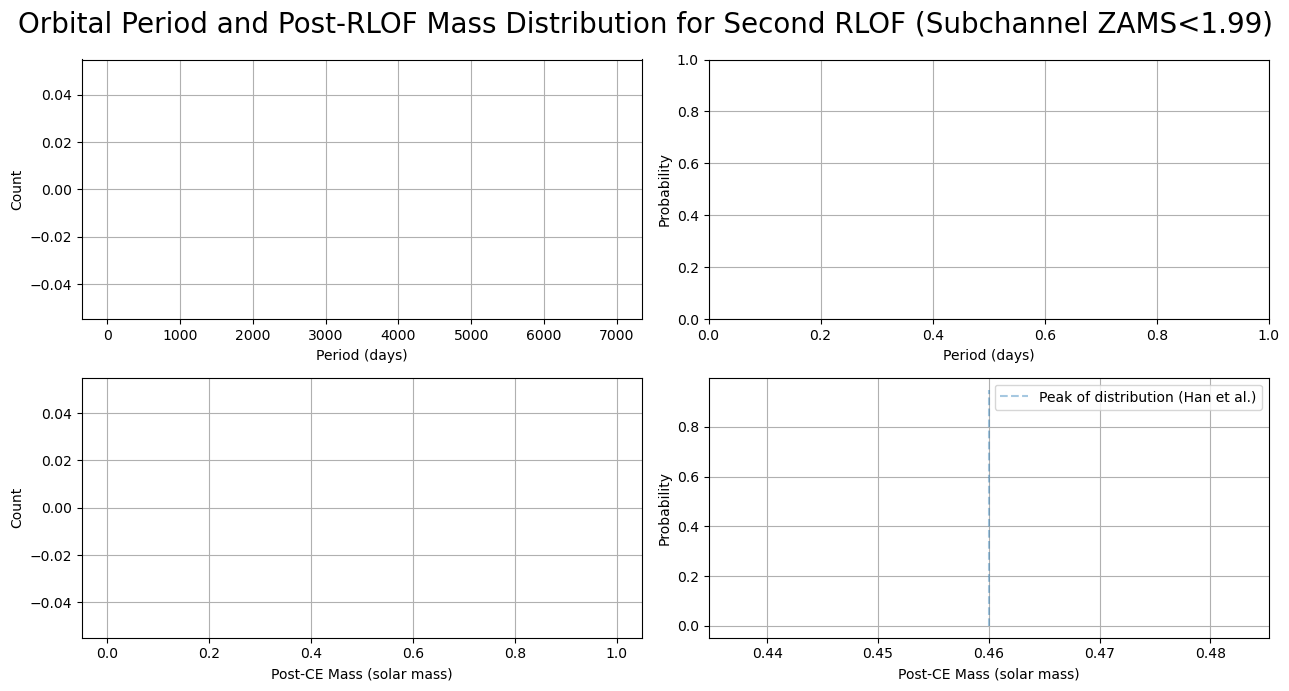

In [33]:
fig, ax = plt.subplots(2,2, figsize=(13,7))

ax[0][0].hist(periods_second_RLOF_subchannel1, period_second_RLOF_subchannel1_bins)
ax[0][0].set_xlabel('Period (days)')
ax[0][0].set_ylabel('Count')
ax[0][0].grid()

#ax[0][1].plot(period_second_RLOF_subchannel1_range, kde_periods_second_RLOF_subchannel1(period_second_RLOF_subchannel1_range), color='skyblue')
#ax[0][1].fill_between(period_second_RLOF_subchannel1_range, kde_periods_second_RLOF_subchannel1(period_second_RLOF_subchannel1_range), color='skyblue', alpha=0.3)
ax[0][1].set_xlabel('Period (days)')
ax[0][1].set_ylabel('Probability')
ax[0][1].grid()

ax[1][0].hist(masses_secondRLOF_subchannel1, masses_secondRLOF_subchannel1_bins)
ax[1][0].set_xlabel('Post-CE Mass (solar mass)')
ax[1][0].set_ylabel('Count')
ax[1][0].grid()

#ax[1][1].plot(masses_secondRLOF_subchannel1_range, kde_masses_secondRLOF_subchannel1(masses_secondRLOF_subchannel1_range), color='skyblue')
#ax[1][1].fill_between(masses_secondRLOF_subchannel1_range, kde_masses_secondRLOF_subchannel1(masses_secondRLOF_subchannel1_range), color='skyblue', alpha=0.3)
ax[1][1].vlines(0.46, 0, 0.95, linestyle='--', alpha=0.4, label='Peak of distribution (Han et al.)')
ax[1][1].set_xlabel('Post-CE Mass (solar mass)')
ax[1][1].set_ylabel('Probability')
ax[1][1].grid()
ax[1][1].legend()

fig.suptitle('Orbital Period and Post-RLOF Mass Distribution for Second RLOF (Subchannel ZAMS<1.99)', fontsize=20) 
fig.tight_layout()

In [41]:
periods_second_RLOF_subchannel2_1 = (2*np.pi/np.sqrt(G)*
           np.sqrt( (RLOF['SemiMajorAxis>MT'][primary_secondRLOF_Subchannel2_bound_full_rlof_mask])**3 / (RLOF['Mass(1)>MT'][primary_secondRLOF_Subchannel2_bound_full_rlof_mask]+RLOF['Mass(2)>MT'][primary_secondRLOF_Subchannel2_bound_full_rlof_mask]))
          )
periods_second_RLOF_subchannel2_2 = (2*np.pi/np.sqrt(G)*
           np.sqrt( (RLOF['SemiMajorAxis>MT'][secondary_secondRLOF_Subchannel2_bound_full_rlof_mask])**3 / (RLOF['Mass(1)>MT'][secondary_secondRLOF_Subchannel2_bound_full_rlof_mask]+RLOF['Mass(2)>MT'][secondary_secondRLOF_Subchannel2_bound_full_rlof_mask]))
           )

periods_second_RLOF_subchannel2 = np.append(periods_second_RLOF_subchannel2_1, periods_second_RLOF_subchannel2_2)

masses_secondRLOF_subchannel2_1 = RLOF['Mass(1)>MT'][primary_secondRLOF_Subchannel2_bound_full_rlof_mask] 
masses_secondRLOF_subchannel2_2 = RLOF['Mass(2)>MT'][secondary_secondRLOF_Subchannel2_bound_full_rlof_mask]

masses_secondRLOF_subchannel2 = np.append(masses_secondRLOF_subchannel2_1, masses_secondRLOF_subchannel2_2)


period_second_RLOF_subchannel2_bins = np.linspace(0,30, 50)
period_second_RLOF_subchannel2_range = np.linspace(0,30, 10000)
kde_periods_second_RLOF_subchannel2 = gaussian_kde(periods_second_RLOF_subchannel2)

masses_secondRLOF_subchannel2_bins = np.linspace(0, 1, 20)
masses_secondRLOF_subchannel2_range = np.linspace(0, 1, 1000)
kde_masses_secondRLOF_subchannel2 = gaussian_kde(masses_secondRLOF_subchannel2)

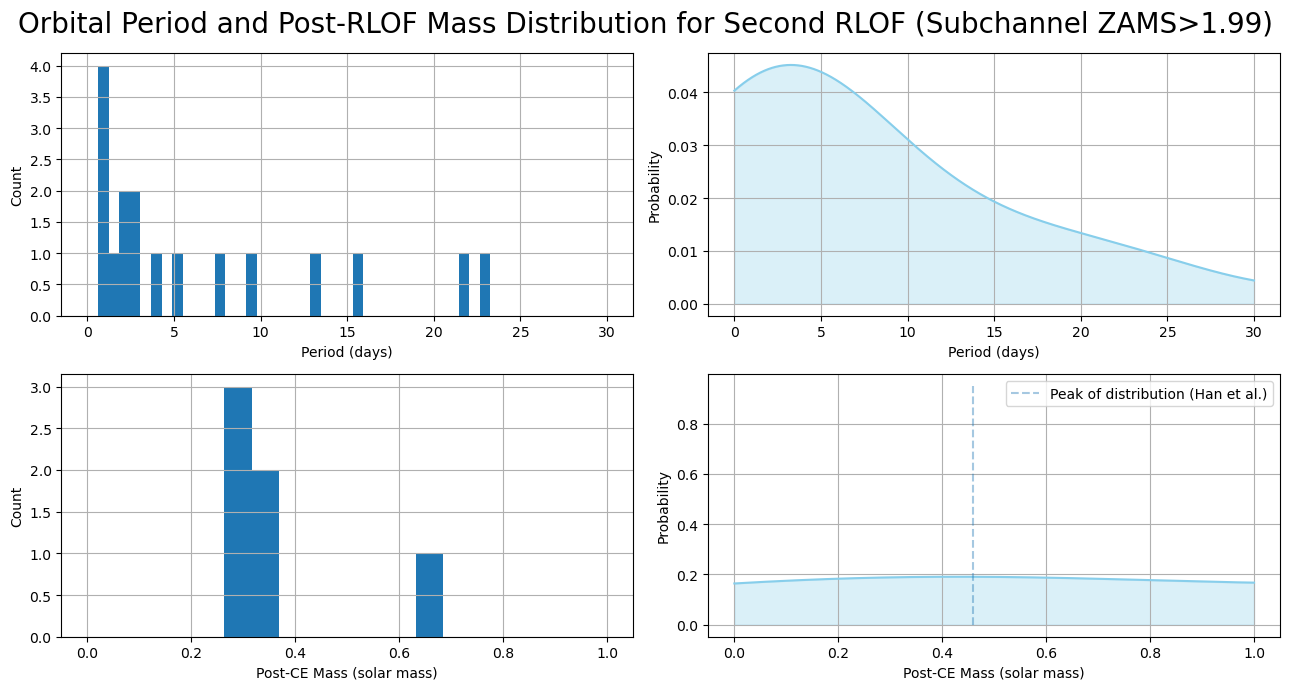

In [42]:
fig, ax = plt.subplots(2,2, figsize=(13,7))

ax[0][0].hist(periods_second_RLOF_subchannel2, period_second_RLOF_subchannel2_bins)
ax[0][0].set_xlabel('Period (days)')
ax[0][0].set_ylabel('Count')
ax[0][0].grid()

ax[0][1].plot(period_second_RLOF_subchannel2_range, kde_periods_second_RLOF_subchannel2(period_second_RLOF_subchannel2_range), color='skyblue')
ax[0][1].fill_between(period_second_RLOF_subchannel2_range, kde_periods_second_RLOF_subchannel2(period_second_RLOF_subchannel2_range), color='skyblue', alpha=0.3)
ax[0][1].set_xlabel('Period (days)')
ax[0][1].set_ylabel('Probability')
ax[0][1].grid()

ax[1][0].hist(masses_secondRLOF_subchannel2, masses_secondRLOF_subchannel2_bins)
ax[1][0].set_xlabel('Post-CE Mass (solar mass)')
ax[1][0].set_ylabel('Count')
ax[1][0].grid()

ax[1][1].plot(masses_secondRLOF_subchannel2_range, kde_masses_secondRLOF_subchannel2(masses_secondRLOF_subchannel2_range), color='skyblue')
ax[1][1].fill_between(masses_secondRLOF_subchannel2_range, kde_masses_secondRLOF_subchannel2(masses_secondRLOF_subchannel2_range), color='skyblue', alpha=0.3)
ax[1][1].vlines(0.46, 0, 0.95, linestyle='--', alpha=0.4, label='Peak of distribution (Han et al.)')
ax[1][1].set_xlabel('Post-CE Mass (solar mass)')
ax[1][1].set_ylabel('Probability')
ax[1][1].grid()
ax[1][1].legend()

fig.suptitle('Orbital Period and Post-RLOF Mass Distribution for Second RLOF (Subchannel ZAMS>1.99)', fontsize=20) 
fig.tight_layout()